In [1]:
# Imports
from langchain_openai import ChatOpenAI

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)

import streamlit


In [2]:
from getpass import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        print(f"Please provide your {var}")
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [3]:
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Teaching Coder 1"

# Main Graph notebook
### This project consists of several sub-systems, ie. sub-graphs, that are all linked together in this notebook.



In [4]:
# Define LLM to be used for all agents

# llm = ChatOpenAI(model="gpt-4-1106-preview") # TOO EXPENSIVE FOR TESTING
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

## Initiate subgraphs, and then collect them in the main graph

In [5]:
from thesis2024.models.coding_agent import CodingMultiAgent
coding_subgraph_class = CodingMultiAgent(llm=llm)
coding_graph = coding_subgraph_class.instanciate_graph()

/opt/homebrew/Caskroom/miniconda/base/envs/src/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"interactive example of how time series data works"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content="tavily_search_results_json response: [{'url': 'https://towardsdatascience.com/your-comprehensive-guide-to-the-basics-of-time-series-modeling-f673398b5df3', 'content': 'According to the COVID-19 example above, the time series can be the observed number of new COVID-19 infections per day for Texas from January 2021 till the end of March 2021. Lags. When you work with time series, you will often hear the term lag. A lag can be seen as the time difference between two points. In the case of daily data, yₜ is the ...'}, {'url': 'https://builtin.com/data-science/time-series-model', 'content': 'These models are used to analyze and forecast the future. Enter time series. A time series is

Python REPL can execute arbitrary code. Use with caution.


{'Code Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nfrom datetime import datetime\\nimport pandas as pd\\n\\n# Sample data\\ndata = {\'Date\': [\'2023-04-01\', \'2023-04-02\', \'2023-04-03\', \'2023-04-04\', \'2023-04-05\'],\\n        \'Closing Price\': [100, 105, 103, 107, 110]}\\n\\n# Convert the date to datetime and sort just in case\\ndf = pd.DataFrame(data)\\ndf[\'Date\'] = pd.to_datetime(df[\'Date\'])\\ndf.sort_values(\'Date\', inplace=True)\\n\\n# Plotting\\nplt.figure(figsize=(10, 5))\\nplt.plot(df[\'Date\'], df[\'Closing Price\'], marker=\'o\')\\nplt.title(\'Stock Price Over Time\')\\nplt.xlabel(\'Date\')\\nplt.ylabel(\'Closing Price (USD)\')\\nplt.grid(True)\\nplt.xticks(rotation=45)\\nplt.tight_layout()\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_repl'}}, name='Code Generator')], 'sender': 'Code Generator'}}
----


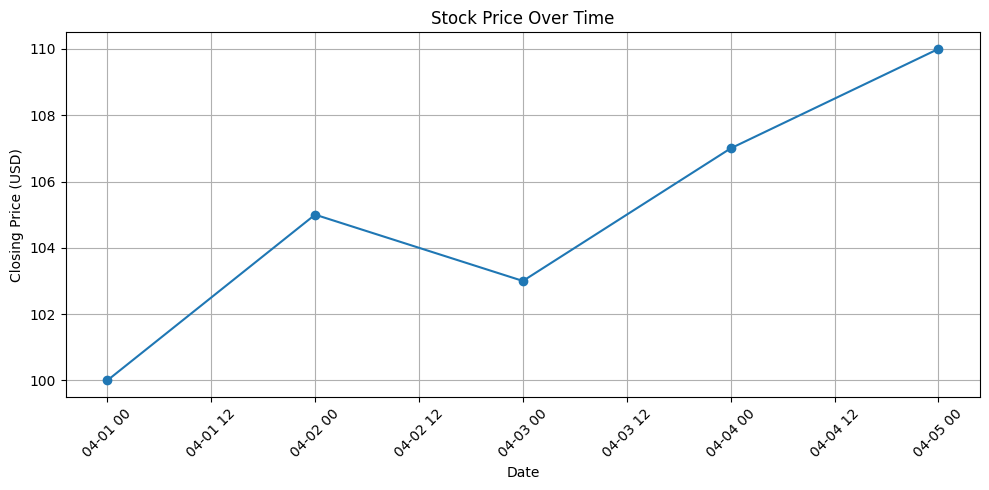

{'call_tool': {'messages': [FunctionMessage(content="python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\nfrom datetime import datetime\nimport pandas as pd\n\n# Sample data\ndata = {'Date': ['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05'],\n        'Closing Price': [100, 105, 103, 107, 110]}\n\n# Convert the date to datetime and sort just in case\ndf = pd.DataFrame(data)\ndf['Date'] = pd.to_datetime(df['Date'])\ndf.sort_values('Date', inplace=True)\n\n# Plotting\nplt.figure(figsize=(10, 5))\nplt.plot(df['Date'], df['Closing Price'], marker='o')\nplt.title('Stock Price Over Time')\nplt.xlabel('Date')\nplt.ylabel('Closing Price (USD)')\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\n\n# Show the plot\nplt.show()\n```\nStdout: ", name='python_repl')]}}
----


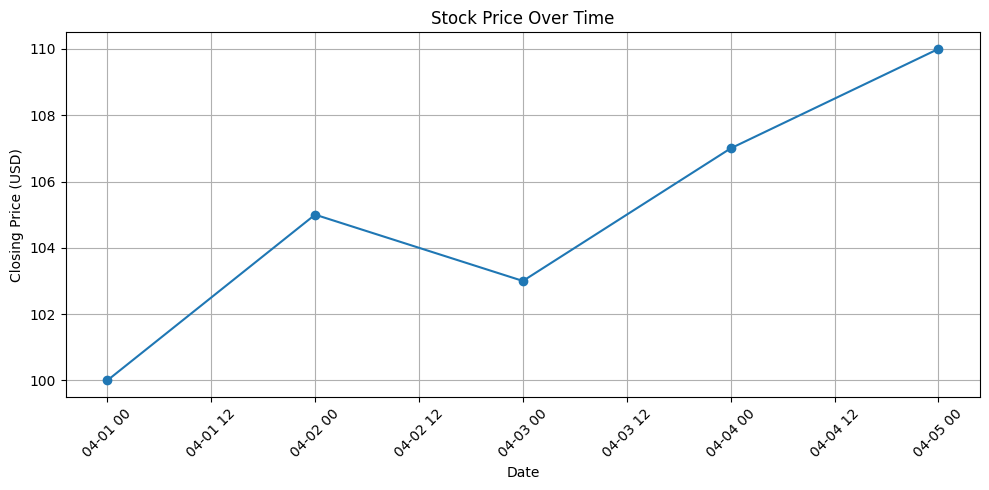

{'Code Generator': {'messages': [HumanMessage(content="We can create a simple interactive example in Python using matplotlib to plot the provided time series data. This will give you an idea of how time series data can be visualized. The interactivity will be basic, allowing you to see the plot and understand the trend of stock prices over the course of five days.\n\nLet's start by plotting the sample data you provided:\n\n- Date: ['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05']\n- Closing Price: [100, 105, 103, 107, 110]\n\nI will create a simple line plot of this data using `matplotlib`, a Python library for creating static, animated, and interactive visualizations in Python. Please note that the interactivity in the matplotlib plot will be limited to tools like pan and zoom, and hovering over the plot to display coordinates. Full interactivity similar to web-based tools like Plotly or D3.js is not possible in this plain Python environment. Let's proceed with th

In [6]:
for s in coding_graph.stream(
{
    "messages": [
        HumanMessage(
            content="Make an interactive example of how time series data works."
        )
    ],
},
# Maximum number of steps to take in the graph
{"recursion_limit": 500},
):
    # print(s)
    print(s)
    print("----")

In [7]:


for s in coding_graph.stream(
{
    "messages": [
        HumanMessage(
            content="Illustrate the deep learning subject of Gradient Descent with an interactive example."
        )
    ],
},
# Maximum number of steps to take in the graph
{"recursion_limit": 10},
):
    print(s)
    print("----")

{'Researcher': {'messages': [HumanMessage(content="To illustrate the subject of Gradient Descent with an interactive example, we can create a simple visualization of how Gradient Descent works in the context of optimizing a linear regression model.\n\nGradient Descent is an optimization algorithm used to minimize the cost function in machine learning models by iteratively moving in the direction of the steepest descent of the cost function. It is commonly used in training deep learning models by updating the model parameters in the direction that minimizes the loss function.\n\nHere is an interactive example to demonstrate Gradient Descent:\n\n1. **Setup:**\n   - Let's consider a simple linear regression model with one feature (x) and one weight parameter (w).\n   - The goal is to fit the line y = wx to a set of data points.\n\n2. **Visualization:**\n   - Display a scatter plot of the data points.\n   - Show the initial line (initial guess) on the plot.\n   - Add a slider for the weigh

interactive(children=(FloatSlider(value=0.05, description='learning_rate', max=0.1, min=0.001, step=0.001), In…

{'Code Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import numpy as np\\nimport matplotlib.pyplot as plt\\nfrom ipywidgets import interact\\n\\n# Generate random data points\\nnp.random.seed(0)\\nx = 2 * np.random.rand(100, 1)\\ny = 4 + 3 * x + np.random.randn(100, 1)\\n\\n# Initial guess for weight parameter w\\nw_init = np.random.randn(1)\\n\\n# Define cost function (Mean Squared Error)\\ndef cost_function(w, x, y):\\n    y_pred = w * x\\n    return np.mean((y_pred - y) ** 2)\\n\\n# Gradient Descent function\\ndef gradient_descent(w_init, x, y, learning_rate, num_iterations):\\n    w = w_init\\n    cost_history = []\\n    for _ in range(num_iterations):\\n        w = w - learning_rate * 2 * np.mean((w * x - y) * x)\\n        cost = cost_function(w, x, y)\\n        cost_history.append(cost)\\n    return w, cost_history\\n\\n# Interactive visualization\\n@interact(learning_rate=(0.001, 0.1, 0.001), num_iterations=(1, 100

GraphRecursionError: Recursion limit of 10 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

In [ ]:
from thesis2024.models.teaching_agent import TeachingMultiAgent
teaching_node = TeachingMultiAgent(llm=llm)

In [ ]:
from thesis2024.models.digital_twin_agent import DigitalTwinAgent
digital_twin_node = DigitalTwinAgent(llm=llm)

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import (AIMessage, BaseMessage, ChatMessage, FunctionMessage, HumanMessage,)
from langgraph.graph import END, StateGraph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


workflow = StateGraph(AgentState)

workflow.add_node("Coder", coding_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

In [28]:


def digital_twin_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a digital twin assistant."
                " You're job is to read through conversation memory, "
                " and update a summary of what the user knows and does not know. "
                " Other assistants will use this summary best umnderstand what the user needs help for. "
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)


def teaching_minded_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful assitant with the goal of helping a student learn as much as possible."
                " Your goal is to best determine how to  "
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"largest 10 mountains in the world"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://en.wikipedia.org/wiki/List_of_highest_mountains_on_Earth\', \'content\': "88 | 4\\n87 |\\n86 | 1\\n85 | 8 1\\n84 | 8\\n83 |\\n82 |\\n81 | 8 6 6 2\\n80 | 9 8 5 3 2\\n79 | 5 4 3 3\\n78 | 9 8 7 6 2 2 1 0\\n77 | 9 9 8 8 5 5 4 1 0 0\\n76 |\\n9 7 6 6 4 1 1\\n75 | 7 7 5 5 4 4 4 3 3 1 1\\n74 | 9 9 9 9 7 6 6 6 5 5 3 3 2 2 2 1 1 1 0 0 0\\n73 | 8 8 8 8 8 6 6 5 5 5 4 2 1 1 1 0\\n72 | 9 9 9 8 8 8 8 7 7 6 6 5 4 4 4 3 2 2 1 1 0 0 0 0 0 0 0\\nGallery[edit]\\n1. All peaks 7,000\\xa0m (23,000\\xa0ft) or higher are located in East, Central or South Asia in a rectangle edged by Noshaq (7,492\\xa0m or 24,580\\xa0ft) on the Afghanistan–Pakistan border in the 

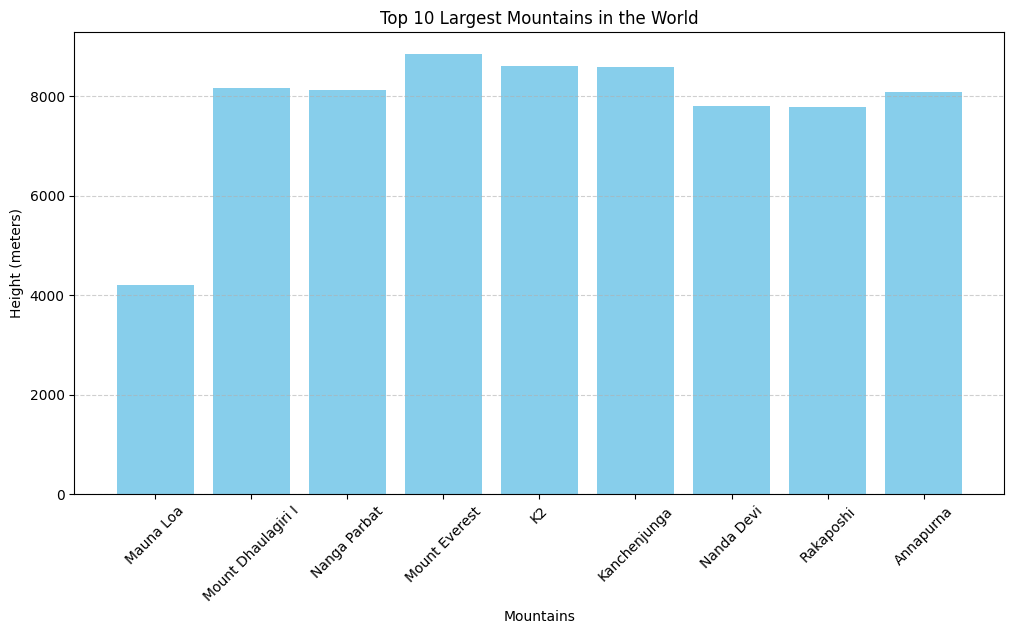

{'Chart Generator': {'messages': [HumanMessage(content="To visualize the heights of the largest 10 mountains in the world, I can create a bar graph showing the heights of these mountains. Let's create the graph with the available data.", additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Mountain data\\nmountains = [\'Mauna Loa\', \'Mount Dhaulagiri I\', \'Nanga Parbat\', \'Mount Everest\', \'K2\', \'Kanchenjunga\', \'Nanda Devi\', \'Rakaposhi\', \'Annapurna\']\\nheights = [4209, 8167, 8126, 8848, 8611, 8586, 7816, 7788, 8091]\\n\\n# Create a bar graph\\nplt.figure(figsize=(12, 6))\\nplt.bar(mountains, heights, color=\'skyblue\')\\nplt.xlabel(\'Mountains\')\\nplt.ylabel(\'Height (meters)\')\\nplt.title(\'Top 10 Largest Mountains in the World\')\\nplt.xticks(rotation=45)\\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.6)\\n\\nplt.show()"}', 'name': 'python_repl'}}, name='Chart Generator')], 'sender': 'Chart Generator'}}
----
{'call_tool':

In [35]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Make a graph over the largest 10 mountains in the world."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 100},
):
    print(s)
    print("----")